In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import datetime
import warnings
import matplotlib.dates as mdates

%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_hdf('model2.h5')

In [48]:
data

,date,total_feed_ton_h_pv,fly_ash_1_ton_h_pv,fly_ash_2_ton_h_pv,main_fan_speed_rpm_pv,separator_speed_rpm_pv,grinding_pressure_bar_pv,mill_injection_water_m3_h_pv,bucket_elv_mtr_pwr_kw_pv,mill_motor_pwr_kw_pv,mill_operation,mill_dp_mbar_pv
0,2019-05-10 11:24:00.000,57.92,0.01,0.10,928.20,717.51,123.0,2.45,4.82,1046.61,1.0,29.79
1,2019-05-10 11:24:30.000,57.72,0.00,0.04,928.20,735.89,120.0,2.46,4.85,1023.69,1.0,30.51
2,2019-05-10 11:25:00.000,58.01,0.01,0.07,928.20,736.68,118.0,2.46,4.88,1024.23,1.0,31.61
3,2019-05-10 11:25:30.000,57.87,0.01,0.09,928.20,747.61,117.0,2.46,4.82,1022.25,1.0,33.71
4,2019-05-10 11:26:00.000,57.80,0.00,0.06,928.20,747.61,119.0,2.46,4.79,1029.91,1.0,34.68
...,...,...,...,...,...,...,...,...,...,...,...,...
188802,31/10/2019 23:52,76.11,0.01,0.07,736.69,795.67,112.0,1.88,5.02,1089.06,1.0,36.52
188803,31/10/2019 23:57,66.85,0.01,0.07,838.13,529.60,70.0,0.00,5.04,560.00,1.0,34.87
188804,31/10/2019 23:58,70.21,0.01,0.11,852.98,529.87,91.0,0.06,5.70,860.31,1.0,36.59
188805,31/10/2019 23:58,70.95,0.02,0.11,855.70,530.13,107.0,0.64,5.13,559.73,1.0,35.19


### Splitting the data set in train and test sets

In [50]:
train_perc = 0.8
test_perc = 0.2

In [51]:
train_split = int(len(data) * train_perc)
train_data = data[:train_split]

test_split = int(len(data) * test_perc)
test_data = data[train_split:(train_split+test_split+1)]

'\nval_split = int(len(data) * val_perc)\nvalidation_data = data[train_split+test_split:(train_split+test_split+val_split)]\n'

### Filtering so as to get rid of the outlier values

In [52]:
mask2 = (train_data['main_fan_speed_rpm_pv']>550) & (train_data['main_fan_speed_rpm_pv']<1100) & (train_data['separator_speed_rpm_pv']>650) & (train_data['separator_speed_rpm_pv']<850) & (train_data['grinding_pressure_bar_pv']>110) & (train_data['grinding_pressure_bar_pv']<123) & (train_data['bucket_elv_mtr_pwr_kw_pv']>4.5) & (train_data['bucket_elv_mtr_pwr_kw_pv']<5.25) & (train_data['mill_dp_mbar_pv']>25) & (train_data['mill_dp_mbar_pv']<45)
train_data = train_data[mask2].reset_index(drop=True)

### Turning the date variable into datetime type, turning it to index for the train set grouping by minute.
### Also, we drop it from the test set cause is unneeded

In [53]:
train_data['date'] = pd.to_datetime(train_data['date'], dayfirst=True)
train_data['date'] = train_data['date'].apply(lambda x: x.replace(second=0))
train_data = train_data.groupby(train_data['date']).mean()

In [54]:
test_data.drop(['date', 'mill_motor_pwr_kw_pv', 'mill_operation'], axis='columns', inplace=True)

### We set the frequency of the by one minute, so as to cover the gaps in the time series
### Then we use interpolation to fill the empty values 

In [56]:
train_data = train_data.asfreq('1T')

In [57]:
train_data = train_data.interpolate(method='linear', axis=0, limit=None, inplace=False, limit_direction='backward', limit_area="inside")

### We shift each input according to their time delay with the output

In [61]:
train_data['total_feed_ton_h_pv'] = train_data['total_feed_ton_h_pv'].shift(periods=6)
train_data['fly_ash_1_ton_h_pv'] = train_data['fly_ash_1_ton_h_pv'].shift(periods=16)
train_data['fly_ash_2_ton_h_pv'] = train_data['fly_ash_2_ton_h_pv'].shift(periods=16)
train_data['main_fan_speed_rpm_pv'] = train_data['main_fan_speed_rpm_pv'].shift(periods=5)
train_data['separator_speed_rpm_pv'] = train_data['separator_speed_rpm_pv'].shift(periods=2)
train_data['grinding_pressure_bar_pv'] = train_data['grinding_pressure_bar_pv'].shift(periods=4)
train_data['mill_injection_water_m3_h_pv'] = train_data['mill_injection_water_m3_h_pv'].shift(periods=3)
train_data['bucket_elv_mtr_pwr_kw_pv'] = train_data['bucket_elv_mtr_pwr_kw_pv'].shift(periods=4)
train_data = train_data.iloc[16:]

### Scaling the variable values because they have different ranges

In [5]:
old_columns = train_data.columns

In [6]:
train_data.columns = ['col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7', 'col8', 'y']

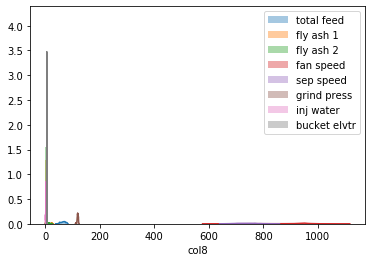

In [8]:
sns.distplot(train_data['col1'], label='total feed')
sns.distplot(train_data['col2'], label='fly ash 1')
sns.distplot(train_data['col3'], label='fly ash 2')
sns.distplot(train_data['col4'], label='fan speed')
sns.distplot(train_data['col5'], label='sep speed')
sns.distplot(train_data['col6'], label='grind press')
sns.distplot(train_data['col7'], label='inj water')
sns.distplot(train_data['col8'], label='bucket elvtr')
plt.legend()

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
mm = MinMaxScaler()

train_mm = mm.fit_transform(train_data)

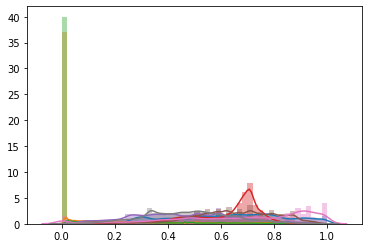

In [11]:
for i in range(8):
    sns.distplot(train_mm[:,i])

### Model evaluation

In [12]:
x = train_data.drop('y', axis=1).values
y = train_data['y'].values

In [13]:
x2 = test_data.drop('mill_dp_mbar_pv', axis=1).values
y2 = test_data['mill_dp_mbar_pv'].values

In [14]:
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [19]:
x = x.copy(order='C')

# Linear Regression
lin_reg = LinearRegression().fit(x, y)
lr_preds = lin_reg.predict(x2)

lr_mae = mean_absolute_error(y2, lr_preds)
lr_mse = np.sqrt(mean_squared_error(y2, lr_preds))
lr_r2 = r2_score(y2, lr_preds, multioutput='variance_weighted')

param_grid = {'alpha': [0.1],
              'solver': ['svd']}

# Ridge
rid_reg = GridSearchCV(Ridge(), param_grid)
rid_reg.fit(x, y)
rd_preds = rid_reg.predict(x2)

rd_mae = mean_absolute_error(y2, rd_preds)
rd_mse = np.sqrt(mean_squared_error(y2, rd_preds))
rd_r2 = r2_score(y2, rd_preds, multioutput='variance_weighted')

In [21]:
# SVR

svr = SVR(max_iter=10000)
svr.fit(x, y)
sv_preds = svr.predict(x2)

sv_mae = mean_absolute_error(y2, sv_preds)
sv_mse = np.sqrt(mean_squared_error(y2, sv_preds))
sv_r2 = r2_score(y2, sv_preds, multioutput='variance_weighted')

In [24]:
param_grid2 = {'max_depth': [8],
               'min_samples_split': [2],
               'min_samples_leaf': [2]}

# Decision Tree
dt = GridSearchCV(DecisionTreeRegressor(), param_grid2)
dt.fit(x, y)
dt_preds = dt.predict(x2)

dt_mae = mean_absolute_error(y2, dt_preds)
dt_mse = np.sqrt(mean_squared_error(y2, dt_preds))
dt_r2 = r2_score(y2, dt_preds, multioutput='variance_weighted')

In [39]:
param_grid3 = {'n_estimators': [100],
               'max_depth': [8],
               'min_samples_leaf': [3]}

# Random Forest
ran_for = GridSearchCV(RandomForestRegressor(), param_grid3)
ran_for.fit(x, y)
rf_preds = ran_for.predict(x2)

rf_mae = mean_absolute_error(y2, rf_preds)
rf_mse = np.sqrt(mean_squared_error(y2, rf_preds))
rf_r2 = r2_score(y2, rf_preds, multioutput='variance_weighted')

In [48]:
param_grid4 = {'loss': ['huber'],
               'alpha': [0.1],
               'max_iter': [1000],
               'learning_rate': ['adaptive']}

# Stohastic Gradient Descent
sgd = GridSearchCV(SGDRegressor(shuffle=False), param_grid4)
sgd.fit(x, y)
sd_preds = sgd.predict(x2)

sd_mae = mean_absolute_error(y2, sd_preds)
sd_mse = np.sqrt(mean_squared_error(y2, sd_preds))
sd_r2 = r2_score(y2, sd_preds, multioutput='variance_weighted')

In [57]:
param_grid5 = {'loss': ['lad'],
               'n_estimators': [100]}

# Gradient Boosting
gbr = GridSearchCV(GradientBoostingRegressor(), param_grid5)
gbr.fit(x, y)
gb_preds = gbr.predict(x2)

gb_mae = mean_absolute_error(y2, gb_preds)
gb_mse = np.sqrt(mean_squared_error(y2, gb_preds))
gb_r2 = r2_score(y2, gb_preds, multioutput='variance_weighted')

In [62]:
param_grid6 = {'max_iter': [100],
               'min_samples_leaf': [35]}

# Hist Gradient Boosting
hgb = GridSearchCV(HistGradientBoostingRegressor(), param_grid6)
hgb.fit(x, y)
hg_preds = hgb.predict(x2)

hg_mae = mean_absolute_error(y2, hg_preds)
hg_mse = np.sqrt(mean_squared_error(y2, hg_preds))
hg_r2 = r2_score(y2, hg_preds, multioutput='variance_weighted')

In [65]:
param_grid7 = {'n_estimators': [100]}

# Bagging
bag = GridSearchCV(BaggingRegressor(), param_grid7)
bag.fit(x, y)
bg_preds = bag.predict(x2)

bg_mae = mean_absolute_error(y2, bg_preds)
bg_mse = np.sqrt(mean_squared_error(y2, bg_preds))
bg_r2 = r2_score(y2, bg_preds, multioutput='variance_weighted')

### Printing the results

In [66]:
print('Linear Regression: ', lr_mae, lr_mse, lr_r2)
print('Ridge Regression:  ', rd_mae, rd_mse, rd_r2)
print('Suppport Vector:   ', sv_mae, sv_mse, sv_r2)
print('Decision Tree:     ', dt_mae, dt_mse, dt_r2)
print('Random Forest:     ', rf_mae, rf_mse, rf_r2)
print('Gradient Descent:  ', sd_mae, sd_mse, sd_r2)
print('Gradient Boosting: ', gb_mae, gb_mse, gb_r2)
print('Hist Grad Boost:   ', hg_mae, hg_mse, hg_r2)
print('Bagging:           ', bg_mae, bg_mse, bg_r2)

Linear Regression:  1.8753043408691006 2.392065674531404 0.002233269730769427
Ridge Regression:   1.8753026596701439 2.392063097188007 0.002235419827346097
Suppport Vector:    2.1893247941869083 2.732484300698858 -0.30196158777228854
Decision Tree:      1.9382344731137116 2.4589333714595494 -0.054329461901373
Random Forest:      1.8944289273873887 2.4027051580180045 -0.006662247803211674
Gradient Descent:   1.8817695559669212 2.4298075208981165 -0.029500505994916715
Gradient Boosting:  1.8407927926451204 2.3201147631424153 0.061354169070787834
Hist Grad Boost:    1.7443073694981266 2.2361418352915843 0.1280702137536497
Bagging:            1.8357170369560416 2.3549132503182424 0.03298625505360342


### Plotting the best 3 models in comparison with the real values

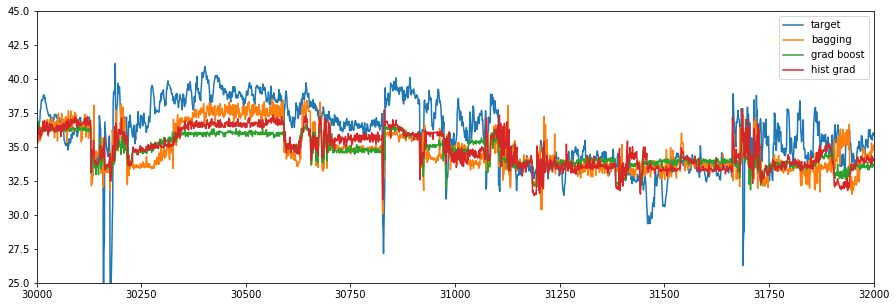

In [78]:
plt.figure(figsize=(15, 5))

plt.plot(range(len(y2)), y2, label='target')
plt.plot(range(len(y2)), bg_preds, label='bagging')
plt.plot(range(len(y2)), gb_preds, label='grad boost')
plt.plot(range(len(y2)), hg_preds, label='hist grad')

plt.xlim(30000, 32000)
plt.ylim(25, 45)

plt.legend()